# <font color=blue>DAPD Normalization part 2 </font>
DAPD Normalization part2 synchronizes shoot phenotypic measurements. It uses the plant leaf number to normalizes time-series measurements, such as the projected rosette area. This method improves accuracy by decreasing the statistical dispersion of time-series of quantitative traits.

### Importing modules
The Python and custom modules are loaded using the import command

In [1]:
import numpy as np
import data
import path
import fitting
import matplotlib.pylab as plt
import matplotlib.transforms as mtransforms
import os
import pandas as pd
from scipy.optimize import curve_fit
from scipy.fftpack import fft, ifft
import sys
from scipy import interpolate
import save
from scipy import stats
import ecoTable
import ecoPlot
import datetime

### Variable declaration
__expID__ is the experiment ID. __daySowing__ is the day when the seeds were sown into the soil. __dayStart__ is the first day of the image acquisition from the sowing day. __dayStop__ is the last day of the image acquisition from the sowing day. __krnl__ is the filter kernel size.

In [2]:
expID, daySowing,  dayStart, dayStop = 'Exp4', '2017-11-01', 12, 34

daySowing = datetime.datetime.strptime(daySowing + ' 00:00', '%Y-%m-%d %H:%M')
tmeStar = datetime.time(6,5,0)
tmeStop = datetime.time(17,50,0)
off = 3

### Experiment Directories
Each experiment has its own set of files which are stored in a specific directory. They are loaded based on the full file directory.

In [3]:
dirCurrent = os.getcwd()
dirParent = os.path.abspath(os.path.join(dirCurrent, os.pardir)) 
root = dirParent + '/'+ expID + '/'
labelDir = root + expID + '_label.csv'
pathPlot = root + expID + '_' + 'plots' +'/'
pathData = root + expID + '_' + 'datasets' +'/'

csvRaw = pd.DataFrame(path.filesEnd(pathData, 'raw.csv'))
csvRaw.columns      = ['file']
csvRaw[['experiment','ecotype', 'feature', 'dataType']] = csvRaw['file'].str.split("_", n = 3, expand = True)
ecotypes = csvRaw.loc[:, 'ecotype'].unique()

if not os.path.exists(pathPlot): os.makedirs(pathPlot) 
    
if not os.path.exists(pathData): os.makedirs(pathData)     

print(csvRaw)

                      file experiment ecotype feature dataType
0  Exp4_Col-0_area_raw.csv       Exp4   Col-0    area  raw.csv
1  Exp4_Col-0_leaf_raw.csv       Exp4   Col-0    leaf  raw.csv


### Read and process csv files 
This section reads the csv files which were generated by the image processing main module. Each csv file has the time and phenotyping measurements such as the rosette area and leaf number.

line =  Col-0


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


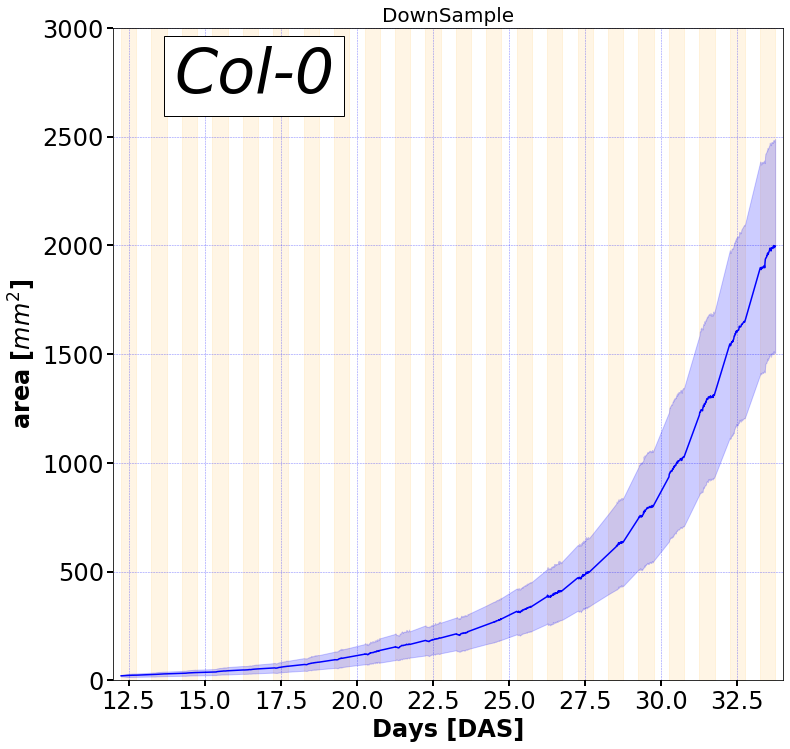

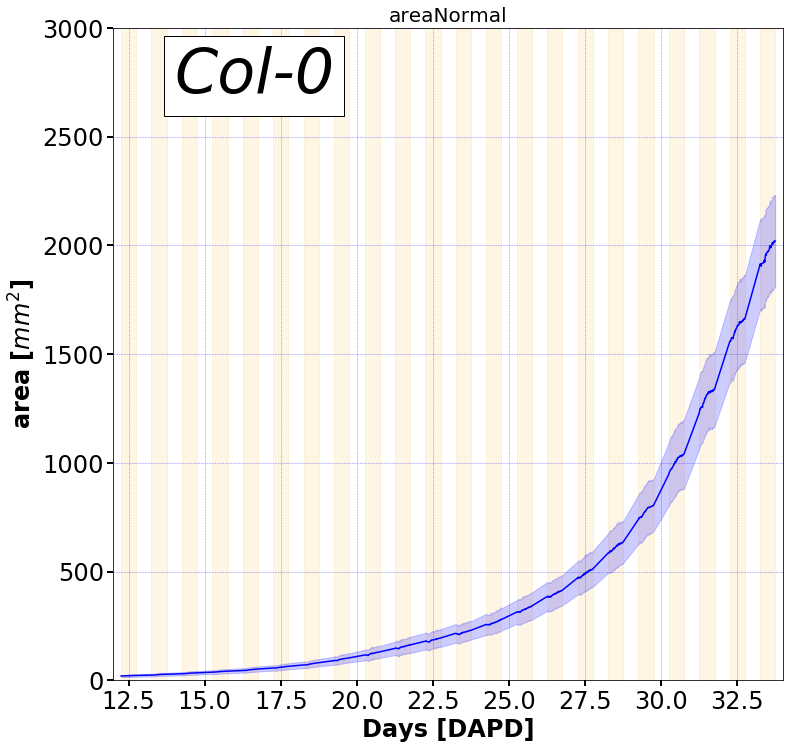

In [4]:
for line in ecotypes:
    
    print('line = ', line)
    leafNum = 10
    ecos = csvRaw[csvRaw.loc[:, 'ecotype'] == line]
    ecos.reset_index(drop=True, inplace=True)
    minVect = ecoTable.minsVector("6:05", "18:00", "15min")
    areaIndex = np.where(ecos.feature == 'area')[0] 
    areaFname = ecos.loc[areaIndex, 'file'].values[0]
    areaFpath = pathData + areaFname
    
    leafIndex = np.where(ecos.feature == 'leaf')[0] 
    leafFname = ecos.loc[leafIndex, 'file'].values[0]
    leafFpath = pathData + leafFname
    areaRaw = pd.read_csv(areaFpath)
    areaRaw.set_index(pd.DatetimeIndex(areaRaw['time']), inplace=True)
    areaRaw.drop(columns=['time', 'mins', 'mean', 'STD', 'var', 'meanFit'], inplace=True)
    areaUpSmpl = areaRaw.resample('5min').asfreq()
    areaUpMean = areaUpSmpl.mean(axis=1)
    areaInterp = areaUpSmpl.copy()
    areaInterp.iloc[0, :] = areaInterp.iloc[0, :].fillna(areaUpMean[0])
    areaInterp.interpolate(method='linear', limit_direction='both', inplace=True)
    areaDwnSmp = ecoTable.seriesDownSampl(areaInterp, minVect, daySowing)
    areaShift, shiftMtxArea = ecoTable.calcShift(areaDwnSmp, 'area', daySowing, leafNum, off)
    
    leafRaw = pd.read_csv(leafFpath)
    leafRaw.set_index(pd.DatetimeIndex(leafRaw['time']), inplace=True)
    leafRaw.drop(columns=['time', 'mins', 'mean', 'STD', 'var', 'meanFit'], inplace=True)
    leafUpSmpl = leafRaw.resample('5min').asfreq()
    leafUpMean = leafUpSmpl.mean(axis=1)
    leafInterp = leafUpSmpl.copy()
    leafInterp.iloc[0, :] = 4
    leafInterp =  np.round(leafInterp.interpolate(method='linear', limit_direction='both'))
    leafDwnSmp = ecoTable.seriesDownSampl(leafInterp, minVect, daySowing)
    leafAdjust, shiftMtxLeaf = ecoTable.calcShift(leafDwnSmp, 'leaf', daySowing, leafNum, off)

    posns = list(filter(lambda x: (x[0] == 'T'), areaRaw.columns.tolist())) 
    shiftMtxAll = pd.DataFrame(columns = ['posn', 'shiftDay'])
    
    for cntP in range(len(posns)):
        posn = posns[cntP]
        sdayLeaf = shiftMtxLeaf.loc[shiftMtxLeaf['posn'] == posn, 'shiftDay'].values[0]
        sdayArea = shiftMtxArea.loc[shiftMtxArea['posn'] == posn, 'shiftDay'].values[0]
        sdayMean = int(np.mean([sdayLeaf, sdayArea]))
        shiftMtxAll.loc[cntP, 'posn'] = posn
        shiftMtxAll.loc[cntP, 'shiftDay'] = sdayMean

    areaAdjust = ecoTable.timeShift(areaDwnSmp, posns, daySowing, shiftMtxAll)

    locat = pd.DataFrame(columns = ['posn', 'camera'])
    locat['posn'] = posns
    areaRaw = ecoTable.STATS(areaRaw, posns, daySowing)
    areaUpSmpl = ecoTable.STATS(areaUpSmpl, posns, daySowing)
    areaInterp = ecoTable.STATS(areaInterp, posns, daySowing)
    areaDwnSmp = ecoTable.STATS(areaDwnSmp, posns, daySowing)
    areaShift = ecoTable.STATS(areaShift, posns, daySowing)
    areaAdjust = ecoTable.STATS(areaAdjust, posns, daySowing)

    ecoPlot.STD(pathPlot, expID, line, 'area', 'DownSample', areaDwnSmp,  locat, dayStart, dayStop)
    ecoPlot.STD(pathPlot, expID, line, 'area', 'areaNormal', areaAdjust,  locat, dayStart, dayStop)
    save.CVS(pathData, expID + '_' + line + '_' + 'area' + '_' + 'DownSample', areaDwnSmp)
    save.CVS(pathData, expID + '_' + line + '_' + 'area' + '_' + 'areaAdjust', areaAdjust)
